In [1]:
import json
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import surface, plotting
from nilearn import datasets
import os
from os.path import join as ospj
import pandas as pd 
from scipy.stats import spearmanr


from collections import defaultdict
import csv
 
from tqdm import tqdm

In [2]:
config_file = "/cbica/projects/luo_wm_dev/code/superficialWM_analyses/config_HCPD.json"

# Read config from the specified file
with open(config_file, "rb") as f:
    config = json.load(f)

dataset = config['dataset']
data_root = config['data_root']
outputs_root = config['outputs_root']
relative_root = ospj(f"{outputs_root}", "all_subjects")

## Where do gyral hops tend to happen?

In [3]:
 
 
# load GM probseg files  
def load_GMprobseg(depth, relative_root):
    """
    Load gifti data.
    Parameters
    -----------
    depth: str
        indicates the depth that vol_to_surf sampled at (e.g. "depth_1p25" or "depth_1")
    relative_root: str
        path 
    """

    # define cohort filename
    cohort_file = f"GMprobseg_{depth}_cohortfile.csv"

    # load cohort csv
    cohort_df = pd.read_csv(ospj(relative_root, "cohortfiles","GMprobseg",cohort_file))
      
    # upload each subject's data
    GM_probsegs = defaultdict(list)
    sources_lists = defaultdict(list)
    
    print("Loading gifti for each subject")
    for ix, row in tqdm(cohort_df.iterrows(), total=cohort_df.shape[0]):   # ix: index of row (start from 0); row: one row of data
        GMprobseg_file = row['source_file']
        gifti_data = nib.load(GMprobseg_file).darrays[0].data
        GM_probsegs[row['scalar_name']].append(gifti_data)   # append to specific scalar_name
         
        sources_lists[row['scalar_name']].append(row['source_file'])  # append source gifti filename to specific scalar_name

     
    return GM_probsegs


In [ ]:
GM_probsegs_depth_1 = load_GMprobseg("depth_1", relative_root)
GM_probsegs_depth_1p25 = load_GMprobseg("depth_1p25", relative_root)
GM_probsegs_depth_3 = load_GMprobseg("depth_3", relative_root)

In [6]:
 
def binarize_GMprobseg(GMprobseg_arrays):
        
    # Assign 1 to vertices (for each subject's array) where GM probability >50%. 0 for vertices < 50%
    for array in GMprobseg_arrays["GMprobseg"]:
        # Convert array to numpy array
        np_array = np.array(array)
        
        # Replace values greater than 50% with 1 and others with 0
        np_array[np_array > 0.5] = 1
        np_array[np_array <= 0.5] = 0
        
        # Update the original array with modified values
        array[:] = np_array.tolist()
    return(GMprobseg_arrays)

GM_probsegs_depth_1_binarized = binarize_GMprobseg(GM_probsegs_depth_1)
GM_probsegs_depth_1p25_binarized = binarize_GMprobseg(GM_probsegs_depth_1p25)
GM_probsegs_depth_3_binarized = binarize_GMprobseg(GM_probsegs_depth_3)




In [7]:

def compute_average_GMprobseg_array(GMprobsegs_binarized_array):
        
    all_arrays = []

    # Loop through the values of the GMprobsegs_binarized_array
    for array_list in GMprobsegs_binarized_array.values():
        # Convert each list to a NumPy array and append to the list
        for array in array_list:
            all_arrays.append(np.array(array))

    # Calculate the average of all arrays
    average_array = np.mean(all_arrays, axis=0)

    return(average_array)

In [8]:
GMprobseg_depth_1_avg = compute_average_GMprobseg_array(GM_probsegs_depth_1_binarized)
lh_depth_1_avg = GMprobseg_depth_1_avg[0:10242]
rh_depth_1_avg = GMprobseg_depth_1_avg[10242:20484]

GMprobseg_depth_1p25_avg = compute_average_GMprobseg_array(GM_probsegs_depth_1p25_binarized)
lh_depth_1p25_avg = GMprobseg_depth_1p25_avg[0:10242]
rh_depth_1p25_avg = GMprobseg_depth_1p25_avg[10242:20484]


GMprobseg_depth_3_avg = compute_average_GMprobseg_array(GM_probsegs_depth_3_binarized)
lh_depth_3_avg = GMprobseg_depth_3_avg[0:10242]
rh_depth_3_avg = GMprobseg_depth_3_avg[10242:20484]
 

In [9]:
def store_gifti(df):
    df = df.astype(np.float32)
    df_gii_data = nib.gifti.gifti.GiftiDataArray(df)
    df_gii = nib.gifti.gifti.GiftiImage(darrays=[df_gii_data])
    return(df_gii)

lh_depth_1_avg_gii = store_gifti(lh_depth_1_avg)
rh_depth_1_avg_gii = store_gifti(rh_depth_1_avg)


lh_depth_1p25_avg_gii = store_gifti(lh_depth_1p25_avg)
rh_depth_1p25_avg_gii = store_gifti(rh_depth_1p25_avg)



lh_depth_3_avg_gii = store_gifti(lh_depth_3_avg)
rh_depth_3_avg_gii = store_gifti(rh_depth_3_avg)

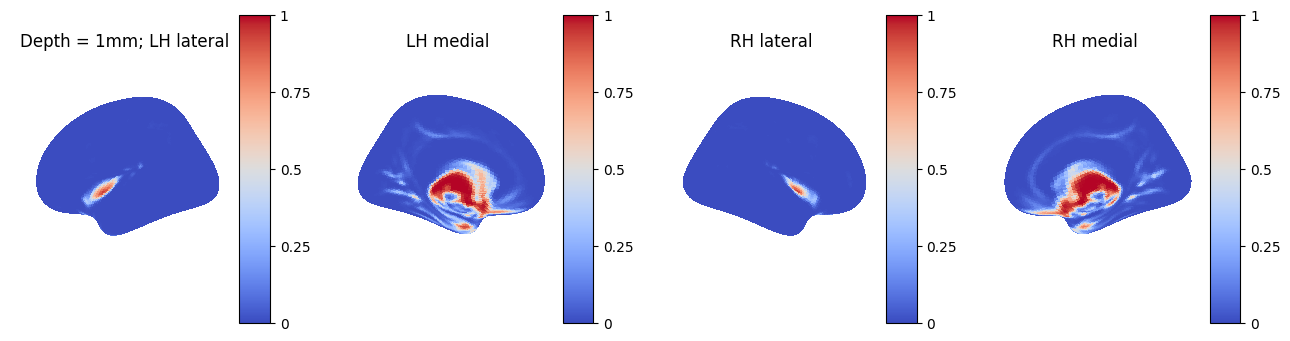

In [63]:
fsaverage = datasets.fetch_surf_fsaverage()

 
fig, axes = plt.subplots(1, 4, figsize=(16, 8), subplot_kw={'projection': '3d'})

# Plot depth 1
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_depth_1_avg_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Depth = 1mm; LH lateral", axes=axes[0], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_depth_1_avg_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', title="LH medial",axes=axes[1], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_depth_1_avg_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="RH lateral", axes=axes[2], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_depth_1_avg_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', title="RH medial",axes=axes[3], cmap="coolwarm", colorbar=True)
 

# Show plot
plt.show()

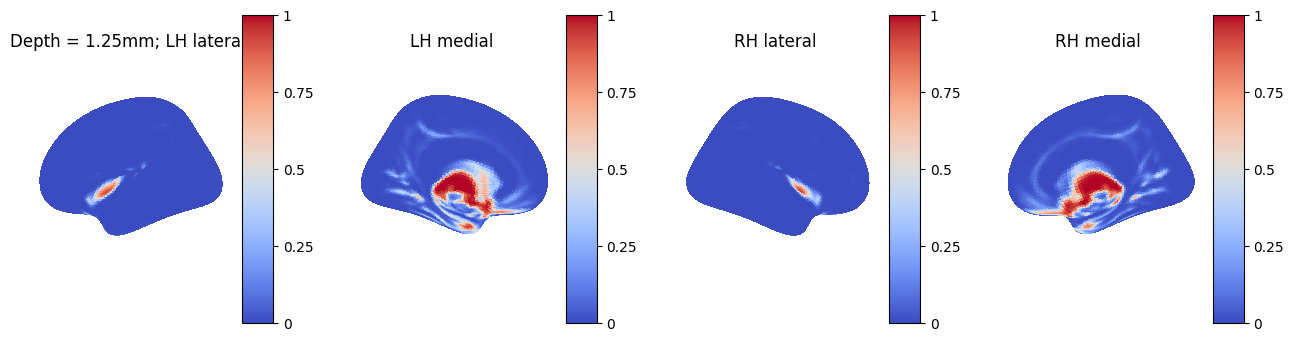

In [64]:
fsaverage = datasets.fetch_surf_fsaverage()

 
fig, axes = plt.subplots(1, 4, figsize=(16, 8), subplot_kw={'projection': '3d'})

# Plot depth 1
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_depth_1p25_avg_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Depth = 1.25mm; LH lateral", axes=axes[0], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_depth_1p25_avg_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', title="LH medial",axes=axes[1], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_depth_1p25_avg_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="RH lateral", axes=axes[2], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_depth_1p25_avg_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', title="RH medial",axes=axes[3], cmap="coolwarm", colorbar=True)
 
 

# Show plot
plt.show()

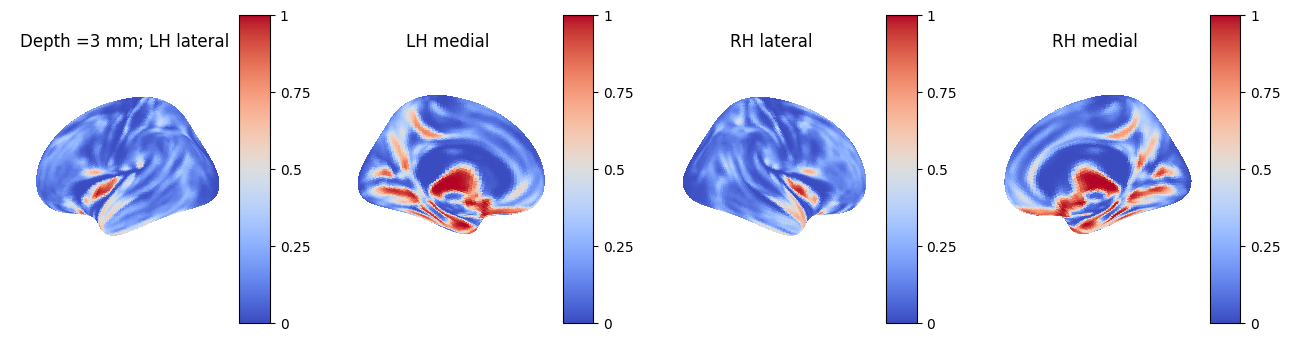

In [11]:
fsaverage = datasets.fetch_surf_fsaverage()

 
fig, axes = plt.subplots(1, 4, figsize=(16, 8), subplot_kw={'projection': '3d'})

# Plot depth 1
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_depth_3_avg_gii.darrays[0].data, bg_map=None, hemi='left', view='lateral', title="Depth =3 mm; LH lateral", axes=axes[0], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_left, surf_map=lh_depth_3_avg_gii.darrays[0].data, bg_map=None, hemi='left', view='medial', title="LH medial",axes=axes[1], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_depth_3_avg_gii.darrays[0].data, bg_map=None, hemi='right', view='lateral', title="RH lateral", axes=axes[2], cmap="coolwarm", colorbar=True)
plotting.plot_surf(fsaverage.infl_right, surf_map=rh_depth_3_avg_gii.darrays[0].data, bg_map=None, hemi='right', view='medial', title="RH medial",axes=axes[3], cmap="coolwarm", colorbar=True)
 
 

# Show plot
plt.show()